## Convolutional autoencoder

In [1]:
## Notebook Control
# decide to load or not the pretrained model
load_good_model2 = True

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.model_selection import KFold # this module is useful to split data into training and test sets

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import pickle

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu") #for debugging
print(f'Selected device: {device}')

if not os.path.exists('data/training'):
    os.makedirs('data/training')

Selected device: cuda


In [3]:
## Dataset
# training and validation will be performed on the training dataset
train_dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True)
# test dataset will only be used for evaluating final model performance
test_dataset  = torchvision.datasets.FashionMNIST('data', train=False, download=True)

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
num_labels = len(label_names)

In [4]:
## Data transformation
train_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    # OneHotEncoder(num_classes=10),
    transforms.ToTensor()
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform


In [5]:
## Model definition
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True),
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            #third linear layer
            nn.Linear(in_features=32, out_features=encoded_space_dim)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=32),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        ) 
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x
        

In [6]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, apply_softmax=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for (image_batch, _) in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        if apply_softmax:
            encoded_data = F.softmax(encoded_data, dim=1)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Add loss to the list
        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    #print(f"Batch Train loss: {train_loss}")
    return train_loss

### Testing function
def validate_epoch(encoder, decoder, device, dataloader, loss_fn, apply_softmax=False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for (image_batch, _) in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            if apply_softmax:
                encoded_data = F.softmax(encoded_data, dim=1)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        #print(f"Batch Validation loss: {val_loss}")
    return val_loss.item()

In [7]:
#useful functions
def plot_losses(train_losses, val_losses, title, save_name=None, label1="Training loss", label2="Validation loss", max_y=0.2):
    fig = plt.figure(figsize=(12,4))
    plt.plot(train_losses, label=label1)
    plt.plot(val_losses, label=label2)
    plt.ylim(0,max_y)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    if save_name is None:
        save_name = title
    fig.savefig("images/"+save_name+".eps",format="eps", dpi=1200, bbox_inches="tight")
    plt.close()

def reset_weights(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.reset_parameters()

In [8]:
# function to get model accuracy
def get_accuracy(encoder, dataset, single_layer=None):
    this_dataloader = DataLoader(dataset, batch_size=20000)
    correct = 0
    total = 0
    with torch.no_grad():
        for (data, label) in tqdm(this_dataloader):
            data, label = data.to(device), label.to(device)
            # Compute the output
            output = encoder(data)
            if single_layer is not None:
                output = single_layer(output)
            # Get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # Add to the total number of correct predictions
            correct += pred.eq(label.view_as(pred)).sum() #.item()
            # Add to the total number of predictions
            total += data.shape[0]
    return correct/total

### Test on examples
def test_on_example(n_example, encoder, decoder, title, save_name=None, test_dataset=test_dataset):
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[n_example][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image')
    plt.tight_layout()
    axs[0].axis('off')
    axs[1].axis('off')
    plt.pause(0.1)
    plt.show()
    if save_name is None:
        save_name = title
    fig.savefig(f"images/{save_name}.png", dpi=1000, bbox_inches='tight')
    plt.close()

#function to find good inputs, where the net is confident
def find_good_inputs(encoder10, test_dataset, device):
    # find an input for each class for which the encoder10 is very confident
    fig, axs = plt.subplots(1, 10, figsize=(15,6))
    inputs = []
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    encoder10.eval()
    for i in range(10):
        found = False
        for (image, label) in test_dataloader:
            if label == i:
                image, label = image.to(device), label.to(device)
                output = encoder10(image)
                output = torch.softmax(output, dim=1)
                pred = output.argmax(dim=1, keepdim=True)
                confidence = output.detach().cpu().numpy()[0][i]
                # check if the prediction is correct
                if pred == label and confidence > 0.95:
                    print(f"{label_names[i]} - confidence: {confidence}")
                    inputs.append(image)
                    # plot image
                    axs[i].imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
                    found = True
                    break
        if not found:
            print(f"{label_names[i]} not found")
    plt.show()
    return inputs

def find_inputs(test_dataset):
    inputs = []
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    for i in range(10):
        found = False
        for (image, label) in test_dataloader:
            if label == i:
                inputs.append(image)
                found = True
                break
        if not found:
            print(f"{label_names[i]} not found")
    return inputs
                

#train function
def train(enc, dec, epochs, train_dataset, test_dataset, loss_fn, optim, device, apply_softmax=False):
    # Define the dataloader
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    # Define the lists to store the losses
    train_losses = []
    test_losses = []
    enc, dec = enc.to(device), dec.to(device)
    enc.train()
    dec.train()
    # Train the model
    for epoch in tqdm(range(epochs)):
        # Train the model
        train_loss = train_epoch(enc, dec, device, train_loader, loss_fn, optim, apply_softmax=apply_softmax)
        # Validate the model
        test_loss = validate_epoch(enc, dec, device, test_loader, loss_fn, apply_softmax=apply_softmax)
        # Add the loss to the list
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return enc, dec, train_losses, test_losses


# 2-dimensional encoded space

## Training

Loaded pretrained model


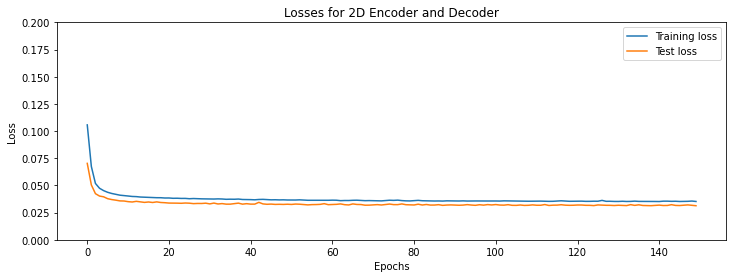

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
#parameters
num_epochs2 = 150 #100 ~ 20 min
encoded_space_dim = 2
encoder2, decoder2 = Encoder(encoded_space_dim), Decoder(encoded_space_dim)
optim2 = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr=1e-3, weight_decay=1e-5)
loss_fn2 = nn.MSELoss()
train_losses = []
val_losses = []

# execute the training loop

if not load_good_model2: #train from scratch
    encoder2, decoder2, train_losses, test_losses = train(encoder2, decoder2, num_epochs2, train_dataset, test_dataset, loss_fn2, optim2, device)
    # save model
    torch.save(encoder2.state_dict(), f"good_models/encoder2_final_{num_epochs2}.pt")
    torch.save(decoder2.state_dict(), f"good_models/decoder2_final_{num_epochs2}.pt")
    # save losses
    with open(f"good_models/losses2_{num_epochs2}.pkl", 'wb') as f:
        pickle.dump([train_losses, test_losses], f)
else: #load pretrained model
    encoder2.load_state_dict(torch.load(f"good_models/encoder2_final_{num_epochs2}.pt"))
    decoder2.load_state_dict(torch.load(f"good_models/decoder2_final_{num_epochs2}.pt"))
    print("Loaded pretrained model")
    #load losses
    with open(f"good_models/losses2_{num_epochs2}.pkl", 'rb') as f:
        train_losses, test_losses = pickle.load(f)

#plot losses
plot_losses(train_losses, test_losses, title="Losses for 2D Encoder and Decoder", save_name=f"losses2_{num_epochs2}", label2="Test loss")

Train loss: 0.031183365732431412
Test loss: 0.03134216368198395


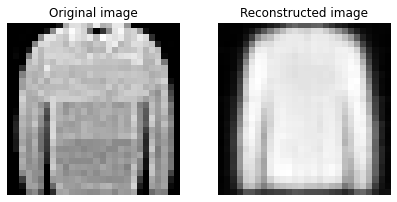

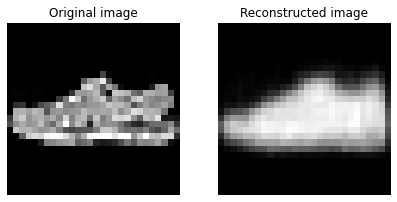

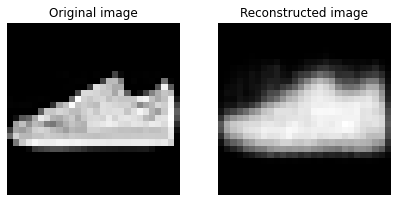

In [10]:
### Test the model
# calculate loss on training set
encoder2, decoder2 = encoder2.to(device), decoder2.to(device)
train_loss = validate_epoch(encoder2, decoder2, device, DataLoader(train_dataset, batch_size=60000), nn.MSELoss())
print(f"Train loss: {train_loss}")
# calculate loss on test set
test_loss = validate_epoch(encoder2, decoder2, device, DataLoader(test_dataset, batch_size=20000), nn.MSELoss())
print(f"Test loss: {test_loss}")

#test on examples
for i in range(20,23):
    test_on_example(i, encoder2, decoder2, title="Test on example 2D-ESD", save_name=f"2D_reconstruction_example_{i}")

In [11]:
### Get the encoded representation of the test samples
def plot_encoded_samples(test_dataset, device, encoder2, title):
    encoded_samples = []
    for sample in tqdm(test_dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder2.eval()
        with torch.no_grad():
            encoded_img  = encoder2(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)

    # Convert to a dataframe
    encoded_samples = pd.DataFrame(encoded_samples)
    encoded_samples

    import plotly.express as px
    %pip install -U kaleido
    fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
        color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
    #set title
    fig.update_layout(title=title)
    fig.show()
    return fig

fig1 = plot_encoded_samples(test_dataset, device, encoder2, "2-D Encoded Test Samples Before Finetuning")
#save fig
if not os.path.exists("images"):
    os.mkdir("images")
fig1.write_image(f"images/encoded2_samples_before.eps")

100%|██████████| 10000/10000 [00:10<00:00, 993.21it/s]


Note: you may need to restart the kernel to use updated packages.


## 2-D Supervised fine tuning and comparison with supervised methods
- 1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task, and compare
classification accuracy and learning speed with results achieved in Homework 1

To fine tune the encoder2, the idea is to create a set of weights from the hidden representation to the output target encoded as a 10-vector (one-hot encoding vector of the class, like class 3 => [0001000000])). The idea for training is divided in steps:
- step 1: fix the encoder2/decoder2 weights and train only the new layer
- step 2: for a specified number of epochs repeat:
    - fix decoder2 and train encoder2 using nn.CrossEntropyLoss() wrt the target
    - fix encoder2 and train decoder2 using nn.MSELoss() wrt to the initial image

In [12]:
## step 1: single layer NN training
# create the single layer NN to match the encoded_space_dim to the 10-dim one-encoded vector
class SingleLayerNN(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc = nn.Linear(encoded_space_dim, 10)
    def forward(self, x):
        return self.fc(x)

slm = SingleLayerNN(encoded_space_dim) #slm = single layer matcher

# step 1: single layer NN training
torch.manual_seed(0)
#params
single_layer_num_epochs = 10
# dataloader
slm_train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#loss
sl_loss_fn = nn.CrossEntropyLoss()
#optimizer
sl_optimizer = torch.optim.Adam(slm.parameters(), lr=1e-3)
# to gpu
slm.to(device)

if not load_good_model2:
    #train loop
    for epoch in tqdm(range(single_layer_num_epochs)):
        #print(f"Epoch {epoch+1}/{single_layer_num_epochs}")
        slm.train()
        epoch_loss = []
        for (data, label) in slm_train_dataloader:
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # use pretrained encoder2 to encode the data
            encoded_data = encoder2(data)
            # Zero the gradients
            sl_optimizer.zero_grad()
            # Compute the output
            output = slm(encoded_data)
            assert output.shape == target.shape
            # Compute the loss
            loss = sl_loss_fn(output, target)
            # Compute the gradients
            loss.backward()
            # Update the weights
            sl_optimizer.step()
            #batch loss
            loss_batch = loss.item()
            epoch_loss.append(loss_batch)
        # Return the average training loss
        epoch_loss = np.mean(epoch_loss)
        # print(f"epoch loss: {epoch_loss}")

    step_1_train_accuracy = get_accuracy(encoder2, train_dataset, single_layer=slm)
    step_1_test_accuracy = get_accuracy(encoder2, test_dataset, single_layer=slm)
    #print train and test accuracy with 3 decimal places
    print(f"Train Accuracy WITHOUT Decoder tuning: {round(step_1_train_accuracy.item()*100, 1)} %")
    print(f"Test Accuracy WITHOUT Decoder tuning: {round(step_1_test_accuracy.item()*100, 1)} %")

- step 2: for a specified number of epochs repeat:
    - fix decoder2 and train encoder2 using nn.CrossEntropyLoss() wrt the target
    - fix encoder2 and train decoder2 using nn.MSELoss() wrt to the initial image

It would be interesting to not fix the encoder2 when the decoder2 is training, in other words use both losses at the same time to update the encoder2. 

UPDATE: it is possible since losses are accumulated when using .backward(). therefore we can try to train for correct target and for correct reconstuction at the same time. Note: recosntruction loss needs to be weighted to match the target loss.

Loaded pretrained models


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

Train Accuracy WITH Decoder tuning: 25.729999542236328 %
Test Accuracy WITH Decoder tuning: 26.139999389648438 %


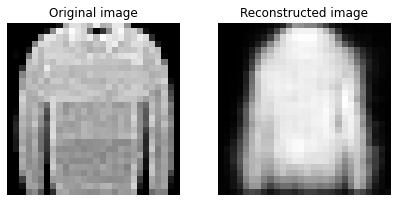

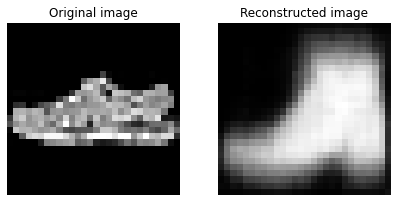

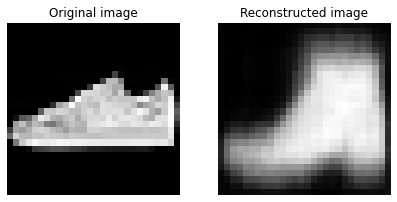

In [13]:
# step 2: fine tuning
torch.manual_seed(0)
step2_num_epochs = 150
target_losses = []
reconstruction_losses = []

#load model
if load_good_model2:
    slm.load_state_dict(torch.load(f'good_models/single_layer_model_{single_layer_num_epochs}.pt'))
    decoder2.load_state_dict(torch.load(f'good_models/decoder2_finetuned_{step2_num_epochs}.pt'))
    #load losses with pickle
    with open('good_models/losses_target_reconstr_encoder2_slm.pkl', 'rb') as f:
        target_losses, reconstruction_losses = pickle.load(f)
    print("Loaded pretrained models")

else:
    # dataloader
    train_dataloader_2 = DataLoader(train_dataset, batch_size=256, shuffle=True)
    #loss
    loss_fn_2 = nn.CrossEntropyLoss()
    dec_loss_fn = nn.MSELoss()
    #optimizer
    params_to_optimize = [
                {'params': encoder2.parameters()},
                {'params': slm.parameters()}, 
                {'params': decoder2.parameters()}
            ]
    optimizer_2 = torch.optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-5)
    # to gpu
    slm.to(device)
    encoder2.to(device)
    decoder2.to(device)

    #train loop
    target_losses = []
    reconstruction_losses = []
    for epoch in range(step2_num_epochs):
        print(f"Epoch {epoch+1}/{step2_num_epochs}")
        slm.train()
        encoder2.train()
        decoder2.train()
        epoch_losses2 = []
        dec_losses = []
        for (data, label) in tqdm(train_dataloader_2):
            # Zero the gradients
            optimizer_2.zero_grad()
            ## DECODER + SINGLE LAYER MATCHER TRAINING
            # target = onehot encoding of label
            target = torch.eye(10)[label] 
            # Move the input and target data to the selected device
            data, target = data.to(device), target.to(device)
            # use pretrained encoder2 to encode the data
            encoded_data = encoder2(data)
            # Compute the output
            output = slm(encoded_data)
            # Compute the loss
            loss2 = loss_fn_2(output, target)
            # Compute the gradients
            loss2.backward(retain_graph=True)
            ## DECODER TRAINING
            # Compute the output
            decoded_data = decoder2(encoded_data)
            # Compute the loss
            dec_loss = 5*dec_loss_fn(decoded_data, data) #5x for more weightage
            # Compute the gradients
            dec_loss.backward()

            # Update the weights
            optimizer_2.step()

            #batch loss
            loss_batch2 = loss2.item()
            epoch_losses2.append(loss_batch2)
            dec_loss_batch = dec_loss.item()
            dec_losses.append(dec_loss_batch)

        # Return the average training loss
        epoch_loss2 = np.mean(epoch_losses2)
        print(f"target loss: {epoch_loss2}")
        target_losses.append(epoch_loss2)
        dec_loss = np.mean(dec_losses)
        print(f"reconstruction loss (x5): {dec_loss}")
        reconstruction_losses.append(dec_loss)

    #plot losses
    plot_losses(target_losses, reconstruction_losses, 
                    title="Target and Reconstruction Losses 2-D Encoder", save_name="losses_target_reconstr_encoder2_slm",
                    label1="Target loss",label2="Reconstruction loss",max_y=1.5)
    
    torch.save(slm.state_dict(), f'good_models/single_layer_model_{single_layer_num_epochs}.pt')
    torch.save(decoder2.state_dict(), f'good_models/decoder2_finetuned_{step2_num_epochs}.pt')
    #save losses using pickle
    with open('good_models/losses_target_reconstr_encoder2_slm.pkl', 'wb') as f:
        pickle.dump([target_losses, reconstruction_losses], f)


#accuracy
step_2_train_accuracy = get_accuracy(encoder2, train_dataset, single_layer=slm)
step_2_test_accuracy = get_accuracy(encoder2, test_dataset, single_layer=slm)
#print train and test accuracy with 3 decimal places
print(f"Train Accuracy WITH Decoder tuning: {step_2_train_accuracy*100} %")
print(f"Test Accuracy WITH Decoder tuning: {step_2_test_accuracy*100} %")

#test on examples
for i in range(20,23):
    test_on_example(i, encoder2, decoder2, title="Test After Tuning 2D-ESD", save_name=f"2D_reconstruction_example_{i}")

In [14]:
## Plot encoded samples after tuning the decoder
fig2 = plot_encoded_samples(test_dataset, device, encoder2, "2-D Encoded Test Samples After Fine Tuning")
fig2.write_image(f"images/encoded2_samples_after.eps")

100%|██████████| 10000/10000 [00:08<00:00, 1153.65it/s]


Note: you may need to restart the kernel to use updated packages.


## Latent space exploration and generation of new samples
- 2 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

Since we are dealing with only 2 hidden dimensions, PCA or t-SNE doesn't make sense.

In this section we will analyze only the new samples generation section

### New samples generation

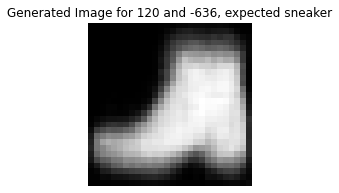

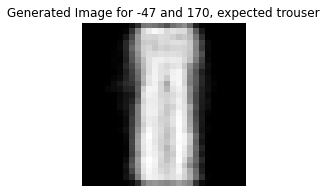

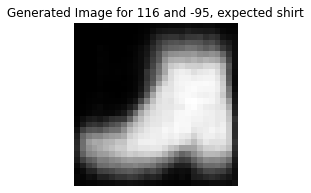

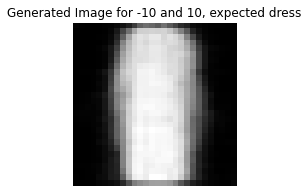

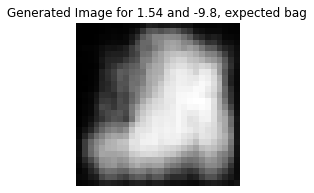

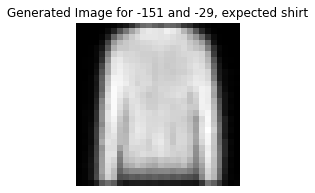

In [24]:
def generate_sample(x, y, expected, decoder2=decoder2):
    encoded_value = torch.tensor([x,y], dtype=torch.float32).unsqueeze(0).to(device)
    #decode sample
    decoder2.eval()
    with torch.no_grad():
        generated_img = decoder2(encoded_value)
    
    fig = plt.figure(figsize=(3,3))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.title(f"Generated Image for {x} and {y}, expected {expected}")
    plt.axis('off')
    plt.show()
    #save plt
    fig.savefig(f"images/generated_sample_{expected}.png", bbox_inches='tight')

## Note: after a retrain these could be way off
generate_sample(120,-636, 'sneaker')
generate_sample(-47, 170, 'trouser')
generate_sample(116, -95, 'shirt')
generate_sample(-10, 10, 'dress')
generate_sample(1.54, -9.8, 'bag')
generate_sample(-151, -29, 'shirt')